## Imports

In [1]:
import os
import h5py
import numpy as np
from numpy.random import random, permutation, randn, normal, uniform, choice
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import keras as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Lambda
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import History 

#from keras.applications.vgg16 import VGG16
#from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input

#from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras import backend as K
K.set_image_dim_ordering('tf')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Using TensorFlow backend.


In [2]:
import itertools
from itertools import chain

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        if titles is not None:
            sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


## Create validation set, sample directories, move images into their directories

In [3]:
%matplotlib inline
%pwd
%cd ..

u'/home/docs1/projects/dl_test_code/dogsvcats/code'

/home/docs1/projects/dl_test_code/dogsvcats


In [4]:
# paths
%pwd
current_dir = os.getcwd()
base_path = current_dir+'/'
data_path_from_base_path = 'data/'
data_path = base_path+'data/'

results_path_from__base_path = 'results/'
results_path = base_path+'results/'
sample_results_path = results_path+'sample/'

weights_path = base_path+'weights/'


u'/home/docs1/projects/dl_test_code/dogsvcats'

In [5]:
train_path_from_base_path = 'data/train/'
train_data_path = data_path+'train/'
validation_path_from_base_path = 'data/valid/'
validation_data_path = data_path+'valid/'
test_path_from_base_path = 'data/test/'
test_data_path = data_path+'test/'

sample_data_path = data_path+'sample/'
sample_train_path_from_base_path = 'data/sample/train/'
sample_train_path = sample_data_path+'train/'
sample_valid_path_from_base_path = 'data/sample/valid/'
sample_valid_path = sample_data_path+'valid/'
sample_test_path_from_base_path = 'data/sample/test/'
sample_test_path = sample_data_path+'test/'

train_data_path
validation_data_path
test_data_path


'/home/docs1/projects/dl_test_code/dogsvcats/data/train/'

'/home/docs1/projects/dl_test_code/dogsvcats/data/valid/'

'/home/docs1/projects/dl_test_code/dogsvcats/data/test/'

## Setup Model and weights

### ___Model Parameters

In [6]:
# dimensions of our images.
learning_rate = 1e-4
batch_size=50
class_mode='categorical'

### ___Base Model Setup

In [7]:
#-------ResNet50----------------------------------------------------------------------------------------------------------------

img_width, img_height = 224, 224
first_layer = Input(shape=(img_width, img_height, 3), name='image_input')
base_model = ResNet50(weights=None, include_top=False, input_tensor=first_layer)

x = base_model.output

x = (BatchNormalization())(x)
x = (GlobalAveragePooling2D())(x)
x = (Dense(1024, activation='relu'))(x)
predictions = (Dense(2, activation='softmax'))(x)

full_model = Model(inputs=first_layer, outputs=predictions)


In [8]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers (weights will not be updated)

for layer in base_model.layers:
    layer.trainable = False


In [9]:
full_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
image_input (InputLayer)         (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        image_input[0][0]                
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

### ___Setup Data

In [10]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.05,
        channel_shift_range=1,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=None)

test_datagen = ImageDataGenerator()

### ___Compile

In [11]:
# compile the model (should be done *after* setting layers to non-trainable)
full_model.compile(optimizer=optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
full_model.load_weights(weights_path+"trained_init_wts.h5")

## Training / Finetuning

In [13]:
nb_epoch = 3

In [14]:
train_batches_for_fit = train_datagen.flow_from_directory(
        train_data_path, target_size=(img_height, img_width), batch_size=batch_size, class_mode=class_mode, 
        shuffle=True)

val_batches_for_fit = test_datagen.flow_from_directory(
        validation_data_path, target_size=(img_height, img_width), batch_size=batch_size, class_mode=class_mode, 
        shuffle=False)

nb_trainsteps_per_epoch = int(round(23000/batch_size))
nb_valsteps_per_epoch = int(round(2000/batch_size))

# fine-tune the model
hist = full_model.fit_generator(
            train_batches_for_fit, steps_per_epoch=nb_trainsteps_per_epoch, nb_epoch=nb_epoch,
            validation_data=val_batches_for_fit,
            nb_val_samples=nb_valsteps_per_epoch)

print 
print ("Completed training/finetuning")
print 

trained_weights_filename = 'trained_final_wts.h5'
full_model.save_weights(weights_path+trained_weights_filename)
training_hist_filename = 'last_training_hist.csv'
pd.DataFrame(hist.history).to_csv(results_path+training_hist_filename)

print ("Completed training/finetuning & saved weights and history")

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


/opt/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/opt/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=460, epochs=3, validation_steps=40)`
  app.launch_new_instance()


Epoch 1/3
460/460 [==============================] - 353s - loss: 0.1165 - acc: 0.9560 - val_loss: 0.0705 - val_acc: 0.9770
Epoch 2/3
460/460 [==============================] - 311s - loss: 0.1108 - acc: 0.9576 - val_loss: 0.0696 - val_acc: 0.9790
Epoch 3/3
460/460 [==============================] - 325s - loss: 0.1083 - acc: 0.9574 - val_loss: 0.0614 - val_acc: 0.9775

Completed training/finetuning

Completed training/finetuning & saved weights and history


['acc', 'loss', 'val_acc', 'val_loss']


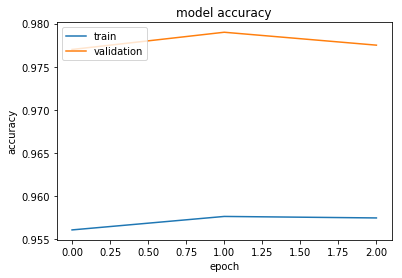

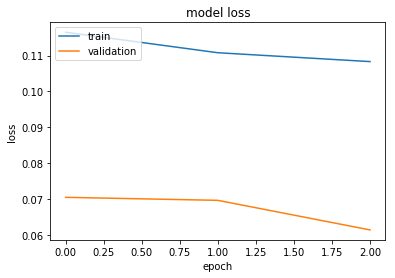

In [15]:
# list all data in history
print(hist.history.keys())
plt1 = plt.plot(hist.history['acc'])
plt1 = plt.plot(hist.history['val_acc'])
plt1 = plt.title('model accuracy')
plt1 = plt.ylabel('accuracy')
plt1 = plt.xlabel('epoch')
plt1 = plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt2 = plt.plot(hist.history['loss'])
plt2 = plt.plot(hist.history['val_loss'])
plt2 = plt.title('model loss')
plt2 = plt.ylabel('loss')
plt2 = plt.xlabel('epoch')
plt2 = plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Analysis

##### __ Error while using predict_generator: Each time predict generator is used, flow_from_directory has to be performed again. If we define flow from Directory once and reuse val_batches, only the first run will be correct. Subsequent runs will have huge prediction loss. So each time predict_generator or fit_generator or any generators are used, generate the data once again by running test_generator or validation_generator once again. -------------For best results, always call flow_from_directory right before the predict_generator or fit_generator call

In [16]:
val_batches = test_datagen.flow_from_directory(
        validation_data_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=False)
val_filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

nb_valsteps_per_epoch = int(round(2000/batch_size))

probs = full_model.predict_generator(val_batches, steps=nb_valsteps_per_epoch, verbose=1)

print ("Completed test predictions")

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,1]
our_labels = np.round(our_predictions)

Found 2000 images belonging to 2 classes.
40/40 [==============================] - 15s    
Completed test predictions


In [17]:
print(our_predictions.shape)
print(our_labels.shape)
print(our_predictions[202])
print(our_labels[202])
print(expected_labels[202])
print(sum(our_predictions[:]))
print(sum(our_labels[:]))
print(sum(expected_labels[:]))
print(sum((abs(our_labels-expected_labels))[:]))

(2000,)
(2000,)
2.17323e-37
0.0
0
967.863689033
962.0
969
45.0


In [18]:
kagy = expected_labels
kagycap = our_predictions
clipval = [0.993, 0.995, 0.997, 0.999, 0.9995, 0.9997, 0.9999]
for x in clipval:
    kagycap_clip = kagycap.clip(min=(1-x), max=x)
    evaluation = (-1) * (kagy * (np.log(kagycap_clip)) + (1-kagy) * (np.log(1-kagycap_clip)))
    score = np.average(evaluation)
    print (str('{0:.4f}'.format(x)) + "      " + str('{0:.5f}'.format(score)))

0.9930      0.06172
0.9950      0.06028
0.9970      0.05881
0.9990      0.05760
0.9995      0.05751
0.9997      0.05760
0.9999      0.05799


[[1012   19]
 [  26  943]]


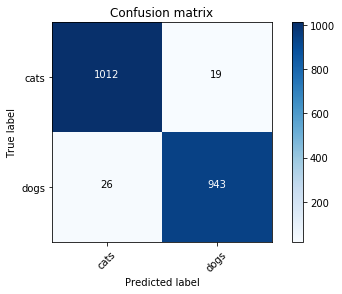

In [19]:
cm = confusion_matrix(expected_labels, our_labels)

plot_confusion_matrix(cm, val_batches.class_indices)

In [20]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(validation_data_path + val_filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 6

Found 45 incorrect labels


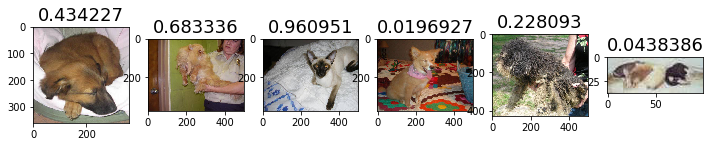

In [21]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print ("Found %d incorrect labels" % len(incorrect))
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

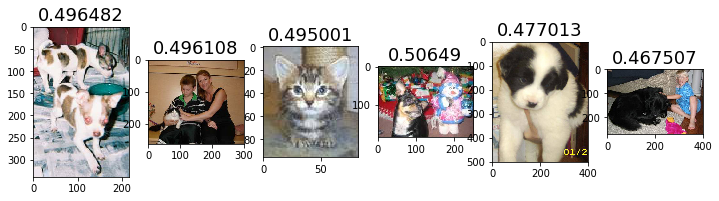

In [22]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

## Test and save results

In [23]:
test_batches = test_datagen.flow_from_directory(
        test_data_path, target_size=(img_height, img_width), batch_size=batch_size, class_mode=class_mode,
        shuffle=False)
filenames = test_batches.filenames

nb_teststeps = int(round(12500/batch_size))

preds = full_model.predict_generator(test_batches, steps=nb_teststeps)

print ("Completed test predictions")

#Save our test results arrays so we can use them again later
predictions_filename = 'testsetpreds_post_training.dat'
filenames_file = 'testsetpreds_filenames.dat'

pd.DataFrame(preds).to_csv(results_path+predictions_filename, index=False)
pd.DataFrame(filenames).to_csv(results_path+filenames_file, index=False)

print ("Completed and saved test predictions")

Found 12500 images belonging to 1 classes.
Completed test predictions
Completed and saved test predictions
